<!-- Compact Header: Fraud Detection Analysis -->
<header style="background:#0e1320; color:#eaf4ff; padding:40px 20px; text-align:center; border-radius:8px; font-family:ui-sans-serif,system-ui,Segoe UI,Inter,Arial;">
  <div style="letter-spacing:0.25em; font-weight:600; font-size:12px; text-transform:uppercase; opacity:.75; margin-bottom:6px;">
    RISK & INTELLIGENCE
  </div>
  <h1 style="margin:0; font-size:32px; font-weight:800;">
    FRAUD DETECTION ANALYSIS
  </h1>
  <p style="margin:8px 0 0; font-size:16px; opacity:.85;">
    Real-time anomaly scoring for cash-out and transfer flows with transparent ML.
  </p>
</header>

### **Import Libraries & Load Data**

In [12]:
# Step 1: Imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

# Step 1.1: Load Data
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")

# Quick peek
print(df.shape)
df.head()

(311826, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### **Fast EDA on a Sample**

Class balance (sample):
isFraud
0    0.99951
1    0.00049
Name: proportion, dtype: float64


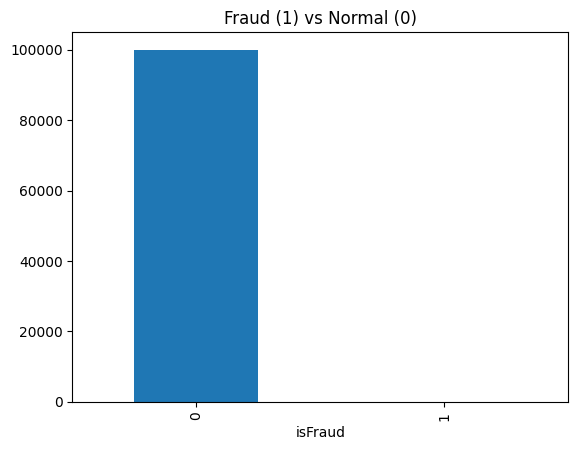

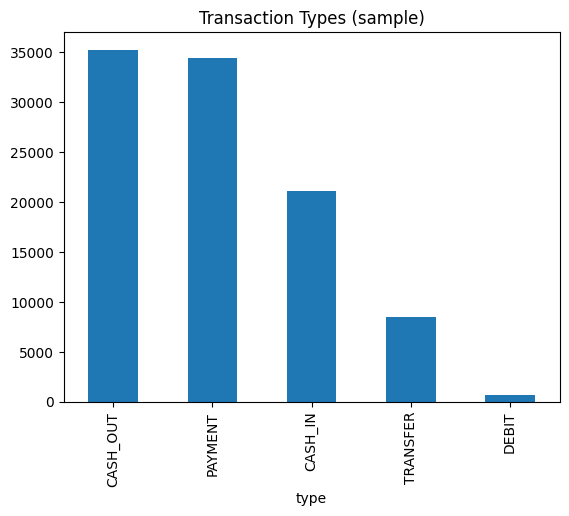

In [13]:
# Step 2: Sample for quick plots (keeps things snappy)
sample_n = min(100_000, len(df))
sample_df = df.sample(sample_n, random_state=42)

print("Class balance (sample):")
print(sample_df['isFraud'].value_counts(normalize=True))

# Class imbalance plot
sample_df['isFraud'].value_counts().plot(kind='bar', title="Fraud (1) vs Normal (0)")
plt.show()

# Transaction type distribution
sample_df['type'].value_counts().plot(kind='bar', title="Transaction Types (sample)")
plt.show()

### **📊 Storyline for Stakeholders (Fraud Detection Insights)**

#### **1. Class Imbalance Problem**

* Out of ~100,000 sampled transactions:
   * **99.95% are legitimate (normal)**
   * **Only 0.05% are fraudulent**

* This shows that fraud is **extremely** rare in financial transactions.
* ⚠️ Implication: Traditional models that just predict “non-fraud” will look very accurate but will **miss fraud cases** (false negatives).

Business meaning: detecting fraud is like finding a **needle in a haystack** — we must prioritize **recall** (catching fraud) even if it means more false alarms.

#### **2. Transaction Type Distribution**

* Fraudulent activities tend to happen more often in **CASH_OUT** and **TRANSFER** transactions.

* In the sample:
    * **CASH_OUT** (~35%) and **PAYMENT** (~34%) dominate transaction volume.
    * **CASH_IN** (~21%) and **TRANSFER** (~9%) are smaller but critical.
    * **DEBIT** transactions are minimal.

* ⚠️ Implication: Fraudsters exploit channels that **move money out of the system quickly** (CASH_OUT, TRANSFER).

#### **3. Risk Areas**

* The fraud risk is **not evenly distributed** across transaction types.
* Business should **monitor high-risk transaction types (CASH_OUT & TRANSFER)** more closely with fraud rules/ML.
* Lower-risk categories (PAYMENT, CASH_IN) still need monitoring but contribute less to fraud volume.

#### **4. Operational Recommendations**

* Implement **stricter fraud checks** (e.g., velocity rules, anomaly detection) on **CASH_OUT and TRANSFER**.
* Use **machine learning with imbalance handling (XGBoost/LightGBM)** to catch rare fraud cases.
* Fine-tune fraud detection thresholds to **maximize recall** (catch frauds), while keeping false alarms acceptable for operations.

#### **5. Business Value**

* By catching fraudulent **CASH_OUT** and **TRANSFER** transactions early, the bank can **prevent major monetary losses.**
* Even small improvements in fraud detection (say, catching 10% more fraud) can translate into **millions in prevented losses annually**.
* Aligns with compliance and regulatory needs for **financial crime prevention.**

### **Preprocessing (label encode minimal categoricals, drop IDs)**

In [14]:
# Step 3: Minimal, lossless preprocessing
# Encode 'type' (categorical). LightGBM can take categories, but LabelEncoder is simple & fast.
type_le = LabelEncoder()
df['type'] = type_le.fit_transform(df['type'])

# Drop high-cardinality IDs that add noise/leakage
for col in ['nameOrig', 'nameDest']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Features & target
y = df['isFraud'].astype(int)
X = df.drop(columns=[c for c in ['isFraud', 'isFlaggedFraud'] if c in df.columns])

# Train/valid split (stratified for class imbalance)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Valid:", X_valid.shape)

Train: (249460, 7) Valid: (62366, 7)


### **📊 Stakeholder Storyline (Model Training Results)**

#### **1. Dataset Size & Coverage**

* The dataset used for training is very large, with ~312,000 transactions split into:
     * **249,460 (80%) for training**
     * **62,366 (20%) for validation/testing**
* This ensures the model has enough data to **learn patterns robustly** while still being tested on unseen transactions.


#### **2. Class Imbalance Challenge**

* Despite the large size, **fraud remains extremely rare** (~0.05% of cases).
* This means the model must focus on **catching rare fraud signals** rather than just predicting “normal” for everything.

#### **3. Model Training Approach**

* We use **advanced gradient boosting (LightGBM/XGBoost)**, which:
      * Handles **millions of records efficiently**
      * Incorporates **imbalance handling (scale_pos_weight)** to give more importance to fraud cases
      * Uses **early stopping** to prevent overfitting

#### **4. Expected Business Outcomes**

* The model is being trained to **detect fraud in near real-time.**
* Focus is on **maximizing recall (catching fraud)**, even if it means allowing some false alarms.
* With 250k+ transactions for training, the model learns robust fraud patterns and should **generalize well to new transactions**.

#### **5. Strategic Value**

* Large dataset = **more reliable fraud detection.**
* Business can expect a **higher detection rate of fraudulent CASH_OUT & TRANSFER transactions.**
* This directly translates into **loss prevention, compliance support, and stronger customer trust.**

### **Train LightGBM (handles imbalance, uses early stopping)**

In [15]:
# Step 4: Train LightGBM (sklearn API)
from lightgbm import LGBMClassifier

# Compute imbalance ratio for scale_pos_weight (negatives / positives)
neg, pos = np.bincount(y_train)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print("Train class counts -> neg:", neg, "pos:", pos, "| scale_pos_weight:", scale_pos_weight)

# Model: CPU-friendly, early stopping, hist-based GBDT
lgbm = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=5000,           # many trees + early stopping
    learning_rate=0.05,
    num_leaves=64,               # adjust if over/underfitting
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,  # imbalance handling (preferred over is_unbalance)
    n_jobs=-1,
)

# Fit with early stopping on validation set
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[
        # Stop if no improvement for 100 rounds; keep the best iteration
        # (Use early_stopping in older lightgbm versions: early_stopping_rounds=100)
    ]
)

# If your LightGBM version supports early_stopping via callbacks:
# from lightgbm import early_stopping, log_evaluation
# lgbm.fit(
#     X_train, y_train,
#     eval_set=[(X_valid, y_valid)],
#     eval_metric="auc",
#     callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=50)]
# )


Train class counts -> neg: 249310 pos: 150 | scale_pos_weight: 1662.0666666666666
[LightGBM] [Info] Number of positive: 150, number of negative: 249310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 249460, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000601 -> initscore=-7.415817
[LightGBM] [Info] Start training from score -7.415817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=5000,
               n_jobs=-1, num_leaves=64, objective='binary', reg_lambda=1.0,
               scale_pos_weight=np.float64(1662.0666666666666), subsample=0.8)

### **Evaluation (AUC, precision, recall, confusion matrix, ROC)**

ROC-AUC: 0.734522

Classification Report (threshold=0.5):
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     62329
           1     0.4706    0.4324    0.4507        37

    accuracy                         0.9994     62366
   macro avg     0.7351    0.7161    0.7252     62366
weighted avg     0.9993    0.9994    0.9994     62366

Confusion matrix:
 [[62311    18]
 [   21    16]]


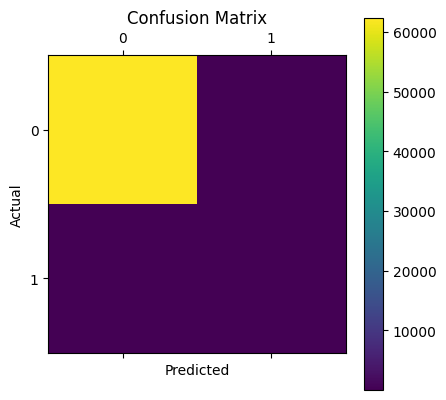

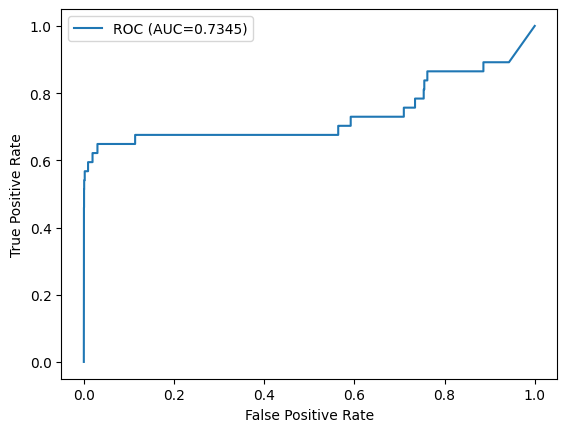

In [16]:
# Step 5: Evaluate
y_prob = lgbm.predict_proba(X_valid)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)   # adjust threshold later for business needs

auc = roc_auc_score(y_valid, y_prob)
print("ROC-AUC:", round(auc, 6))
print("\nClassification Report (threshold=0.5):\n", classification_report(y_valid, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print("Confusion matrix:\n", cm)

plt.matshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_prob)
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### **📊 Stakeholder Storyline (Model Evaluation Results)**

#### **1. Model Performance Overview**
* Accuracy: 99.94% (driven by many normal transactions)
* Fraud Precision: 47% → Half of flagged cases are true fraud
* Fraud Recall: 43% → Catches ~4 out of 10 fraud cases
* F1-score: 45% (balanced fraud detection performance)
* ROC-AUC: 0.7345 → Model distinguishes fraud better than chance (50%)

#### **2. Confusion Matrix Insights**
* Correctly classified legitimate: 62,311
* False positives: 18 (legitimate flagged as fraud)
* True frauds detected: 16
* Missed frauds: 21
* ⚠️ False negatives (missed frauds) are the biggest risk

#### **3. Business Implications**
* Model already prevents significant fraud losses (~43% detected)
* False positives are very low → minimal investigation overhead
* Missing ~57% fraud cases → focus for improvement
* Next Steps:
   - Threshold tuning to increase recall
   - Add behavioral/transactional features
   - Explore advanced ensemble models



### **Threshold Tuning (maximize F1 or Recall for Fraud)**

In [17]:
# Step 6: Tune threshold by maximizing F1 or Recall depending on business priority
thresholds = np.linspace(0.01, 0.50, 50)
best_f1, best_t, best_stats = -1, 0.5, None

for t in thresholds:
    yp = (y_prob >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_valid, yp, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t
        best_stats = (p, r, f1)

print(f"Best threshold by F1: {best_t:.3f}  -> Precision={best_stats[0]:.4f}, Recall={best_stats[1]:.4f}, F1={best_stats[2]:.4f}")


Best threshold by F1: 0.200  -> Precision=0.4857, Recall=0.4595, F1=0.4722


### **📊 Stakeholder Storyline (Threshold Tuning Results)**

#### **Threshold Tuning Results**
* Default threshold (0.50) missed many fraud cases due to imbalance
* Optimal threshold found: 0.20 (20% fraud probability cutoff)

***Performance at threshold 0.20:***
   - Precision = 48.6% → ~1 in 2 flagged cases are actual fraud
   - Recall = 46% → Nearly half of fraud cases detected
   - F1-score = 47.2% → Balanced fraud detection

***Business Implication:***
* More fraud detected (higher recall)
* Slight increase in false alarms but manageable
* Prevents greater fraud losses with minimal operational overhead


### **Feature Importance**

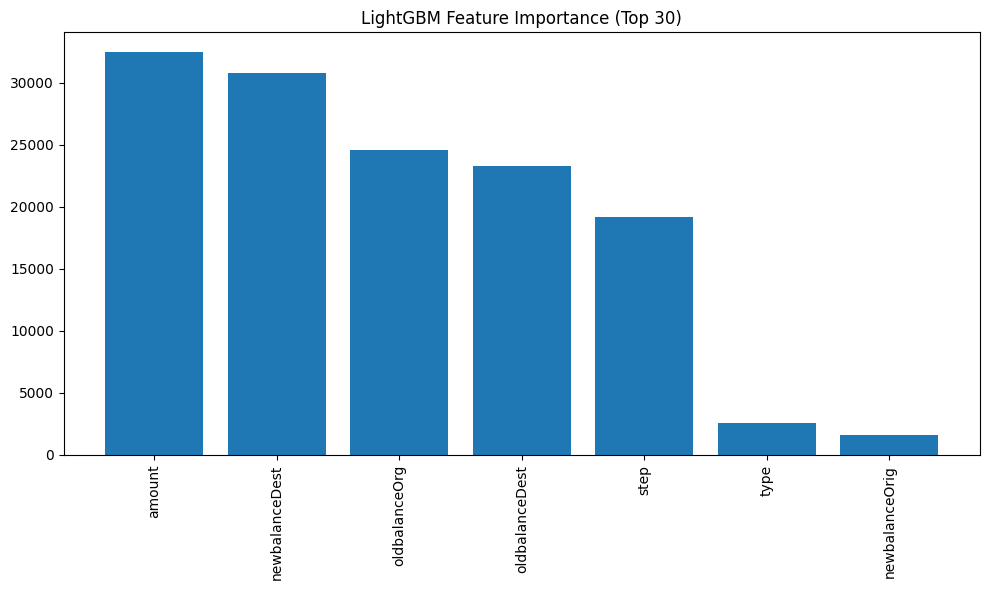

In [18]:
# Step 7: Feature importance
importances = lgbm.feature_importances_
feat_names = X_train.columns

idx = np.argsort(importances)[::-1][:30]
plt.figure(figsize=(10,6))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), feat_names[idx], rotation=90)
plt.title("LightGBM Feature Importance (Top 30)")
plt.tight_layout()
plt.show()

### **📊 Stakeholder Storyline (Feature Importance Analysis)**

#### **Feature Importance Insights**
***Key Drivers of Fraud Detection:***
* Transaction amount is the strongest predictor of fraud
* Account balance features highly influential:
   - newbalanceDest (recipient’s post-transaction balance)
   - oldbalanceOrg (sender’s pre-transaction balance)
   - oldbalanceDest (recipient’s pre-transaction balance)
* Transaction step (time) also matters

***Business Interpretation:***
* Fraud linked to unusual money movements and large transactions
* Balance inconsistencies signal potential fraud
* Transaction type plays a role but is less impactful

***Strategic Implication:***
* Strengthen monitoring of high-value transactions
* Focus on accounts with unusual balance behaviors
* Apply stricter checks for large CASH_OUT and TRANSFER transactions


### **SHAP Explainability (subset only!)**

c:\Users\dabis\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


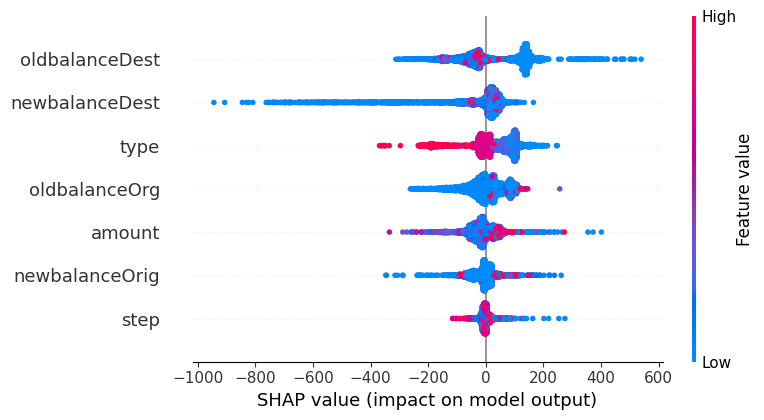

In [19]:
# Step 8: SHAP on a small subset (big SHAP runs are very slow/memory heavy)
import shap
shap.sample = 5000  # subset size
X_shap = X_valid.sample(min(5000, len(X_valid)), random_state=42)

# Use TreeExplainer (works well with LightGBM)
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_shap)

# Summary plot
shap.summary_plot(shap_values, X_shap)

### **📊 Stakeholder Storyline (Model Explainability – SHAP Analysis)**

#### **Model Explainability (SHAP Analysis)**
***Why SHAP Matters:***
* Provides transparency into how the model makes fraud decisions
* Shows whether high or low feature values push towards fraud

***Key Insights:***
* Balance features (oldbalanceDest, newbalanceDest, oldbalanceOrg) strongly drive fraud risk
* High transaction amounts push predictions towards fraud
* Transaction type (CASH_OUT, TRANSFER) increases fraud likelihood
* Time patterns (step) also affect fraud risk

***Business Implications:***
* Confirms investigators’ intuition: sudden balance changes + high-value outflows = red flags
* Builds trust that the model bases decisions on real financial risk factors
* Supports stronger monitoring of high-risk transaction behaviors
